#### **Installing Neccesary packages**

In [27]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Import NumPy for numerical operations
import numpy as np

# Import Matplotlib for visualization
import matplotlib.pyplot as plt

# Import other useful libraries
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

!pip install scikit-learn

In [28]:
import zipfile
import os
import shutil

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
zip_path = '/content/drive/MyDrive/skin_lesion_xf.zip'

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dldataset')

In [30]:
# Define paths for training, validation, and test data
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'
test_dir = '/content/dataset/test'

#### **let's view some of our images**

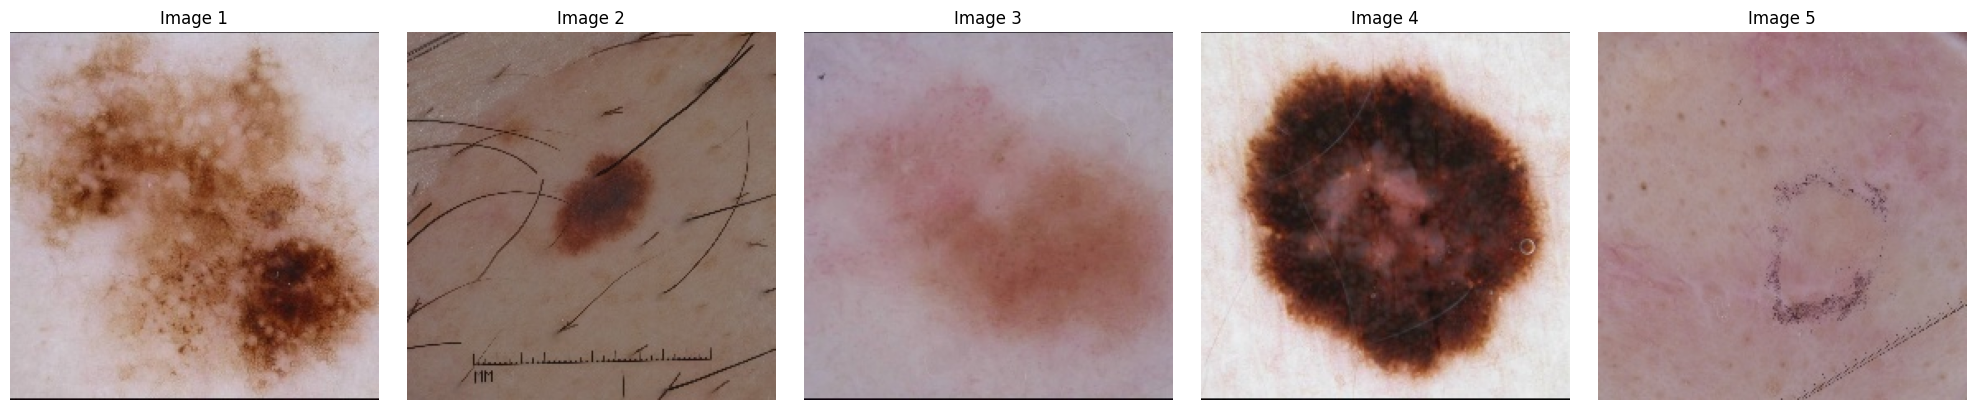

In [31]:

import matplotlib.pyplot as plt
from PIL import Image

# paths to the image files
image_paths = [
    '/content/dldataset/skin_lesion/val_balanced/mel/ISIC2017_0000049_mel.jpg',
    '/content/dldataset/skin_lesion/val_balanced/mel/ISIC2017_0012450_mel.jpg',
    '/content/dldataset/skin_lesion/train_balanced/mel/ISIC2017_0000026_mel.jpg',
    '/content/dldataset/skin_lesion/train_balanced/mel/ISIC2017_0000029_mel.jpg',
    '/content/dldataset/skin_lesion/test_isic_2017/mel/ISIC_0012258.jpg'
]

# Plot images in a single row
plt.figure(figsize=(20, 4))

for i, image_path in enumerate(image_paths):
    plt.subplot(1, 5, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image {i + 1}')

plt.tight_layout()  #
plt.show()


In [32]:
!ls /content/dldataset/skin_lesion/

test_isic_2017	train_balanced	val_balanced


#### **Image Augmentation and Transformatio**n

In [33]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets

# Define data augmentation and preprocessing transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(50),  # Randomly rotate images by up to 30 degrees
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.RandomResizedCrop(224),  # Randomly crop and resize images to 224x224
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize images to 256x256
        transforms.CenterCrop(224),  # Crop the center 224x224 region
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Define image datasets
dataset_dir = '/content/dldataset/skin_lesion'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(dataset_dir, 'train_balanced'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(dataset_dir, 'val_balanced'), data_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(dataset_dir, 'test_isic_2017'), data_transforms['test'])
}

#### **Creating Data Loaders**

In [34]:
import torch

# Define data loaders
batch_size = 64
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}



#### **Model Selection**

In [35]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load the pre-trained DenseNet-121 model with ImageNet weights
model = models.resnet152(pretrained=True)

# Replace the final fully connected layer for binary classification (melanoma vs. non-melanoma)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer with 2 classes (melanoma, non-melanoma)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 58.9MB/s]


#### **Training and Evaluation**

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define the model architecture
model = models.resnet152(pretrained=True)

# Replace the final fully connected layer for binary classification (melanoma vs. non-melanoma)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer will be 2 classes (melanoma, non-melanoma)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


# Implement learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=9, verbose=True)

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define number of epochs
num_epochs = 15

# Training and evaluation loop
for epoch in range(num_epochs):
    for phase in ['train', 'val']:  # Iterate over training and validation phases
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluation mode

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Iterate over batches of data using the corresponding data loader
        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients during training
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):  # Enable gradient computation only during training
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only during training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for the current phase
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_accuracy = correct_predictions / total_samples

         # Store loss and accuracy metrics
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_accuracy)

        # Print epoch statistics
        print(f'Phase: {phase}, Epoch: {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

# After training, perform final evaluation on the test set (if available)
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

# Calculate final test accuracy
test_accuracy = test_correct / test_total
print(f'Final Test Accuracy: {test_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Phase: train, Epoch: 1, Loss: 0.4865, Accuracy: 0.7639
Phase: val, Epoch: 1, Loss: 0.4341, Accuracy: 0.7875
Phase: train, Epoch: 2, Loss: 0.4253, Accuracy: 0.8016
Phase: val, Epoch: 2, Loss: 0.4073, Accuracy: 0.8089
Phase: train, Epoch: 3, Loss: 0.4088, Accuracy: 0.8081
Phase: val, Epoch: 3, Loss: 0.3944, Accuracy: 0.8231
Phase: train, Epoch: 4, Loss: 0.3811, Accuracy: 0.8256
Phase: val, Epoch: 4, Loss: 0.3806, Accuracy: 0.8206
Phase: train, Epoch: 5, Loss: 0.3692, Accuracy: 0.8332
Phase: val, Epoch: 5, Loss: 0.3868, Accuracy: 0.8236
Phase: train, Epoch: 6, Loss: 0.3651, Accuracy: 0.8337
Phase: val, Epoch: 6, Loss: 0.3814, Accuracy: 0.8303
Phase: train, Epoch: 7, Loss: 0.3413, Accuracy: 0.8454
Phase: val, Epoch: 7, Loss: 0.3756, Accuracy: 0.8318
Phase: train, Epoch: 8, Loss: 0.3419, Accuracy: 0.8444
Phase: val, Epoch: 8, Loss: 0.3885, Accuracy: 0.8298
Phase: train, Epoch: 9, Loss: 0.3354, Accuracy: 0.8489
Phase: val, Epoch: 9, Loss: 0.3763, Accuracy: 0.8405
Phase: train, Epoch: 10, Los

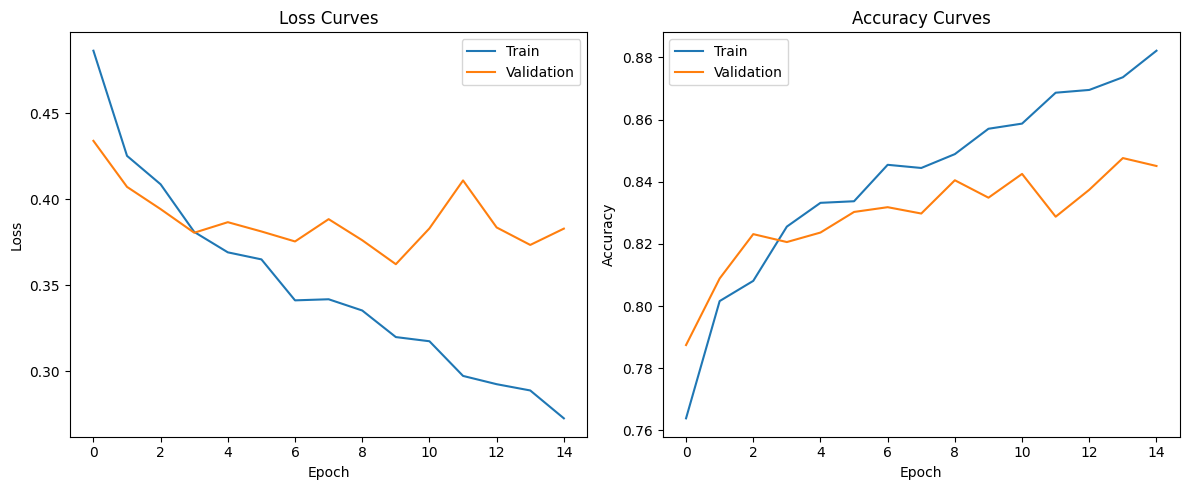

In [37]:

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### **Saving our Model**

In [ ]:
import os

# Create the directory if it doesn't exist
model_dir = '/content/drive/My Drive/models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'skin_lesion_model.pth')
torch.save(model.state_dict(), model_path)

#### **Let's test our models**

Downloading...
From (original): https://drive.google.com/uc?id=1-XH0-OCkT6NLvZV2-GyDGV9Nq8xIRKq3
From (redirected): https://drive.google.com/uc?id=1-XH0-OCkT6NLvZV2-GyDGV9Nq8xIRKq3&confirm=t&uuid=dd5ea5f8-2871-4e55-b067-641c259544e0
To: /content/model.pth
100%|██████████| 234M/234M [00:04<00:00, 57.5MB/s]


Model loaded successfully.


Downloading...
From: https://drive.google.com/uc?id=1gP-DWZ69x2PwEAJyrbAl7ceVh3IG6H7t
To: /content/input_image.jpg
100%|██████████| 57.5k/57.5k [00:00<00:00, 79.1MB/s]


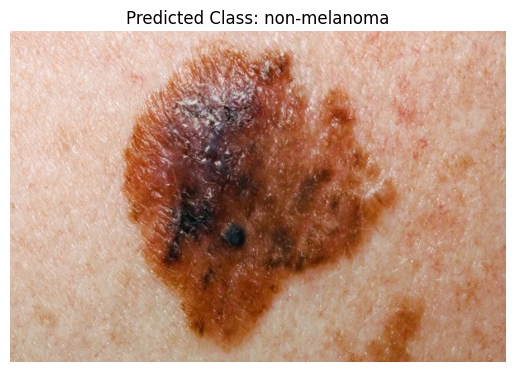

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import gdown

# Download the model file from the Google Drive link
file_url = 'https://drive.google.com/uc?id=1-XH0-OCkT6NLvZV2-GyDGV9Nq8xIRKq3'
output_path = '/content/model.pth'  # Specify the path to save the downloaded model
gdown.download(file_url, output_path, quiet=False)

# Attempt to load the model file
try:
    # Load the pre-trained ResNet-152 model
    model = models.resnet152(pretrained=False)  # Assuming ResNet-152 was used during training
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # Modify the output layer for binary classification

    # Load the trained model weights
    model_state_dict = torch.load(output_path, map_location=torch.device('cpu'))
    model.load_state_dict(model_state_dict)

    # Set the model to evaluation mode
    model.eval()

    print("Model loaded successfully.")

    # Define image transformations for preprocessing
    data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Define the URL for your image file
    image_url = 'https://drive.google.com/uc?id=1gP-DWZ69x2PwEAJyrbAl7ceVh3IG6H7t'

    # Specify the path to save the downloaded image file
    image_path = '/content/input_image.jpg'

    # Download the image file from Google Drive
    gdown.download(image_url, image_path, quiet=False)

    # Load and preprocess the input image
    input_image = Image.open(image_path)
    input_tensor = data_transform(input_image).unsqueeze(0)  # Add batch dimension

    # Perform inference (make predictions)
    with torch.no_grad():
        output = model(input_tensor)

    # Get the predicted class
    _, predicted_idx = torch.max(output, 1)
    predicted_class = predicted_idx.item()

    # Define class labels
    class_names = ['non-melanoma', 'melanoma']  # Replace with your actual class names

    # Display the input image and predicted class
    plt.imshow(input_image)
    plt.title(f'Predicted Class: {class_names[predicted_class]}')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error loading model: {e}")


#### **Testing with multiple images**

Downloading...
From (original): https://drive.google.com/uc?id=1-XH0-OCkT6NLvZV2-GyDGV9Nq8xIRKq3
From (redirected): https://drive.google.com/uc?id=1-XH0-OCkT6NLvZV2-GyDGV9Nq8xIRKq3&confirm=t&uuid=262ddfa9-bd14-4537-8bfa-87d990ce2dd9
To: /content/model.pth
100%|██████████| 234M/234M [00:01<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gP-DWZ69x2PwEAJyrbAl7ceVh3IG6H7t
To: /content/image1.jpg
100%|██████████| 57.5k/57.5k [00:00<00:00, 31.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pN62pvP0I7tRGGpZbH90eiZmPuAasC-h
To: /content/image2.jpg
100%|██████████| 444k/444k [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SIKvqNJsxgTkUKFEEzShLETCe1xyv7bZ
To: /content/image3.jpg
100%|██████████| 181k/181k [00:00<00:00, 91.3MB/s]


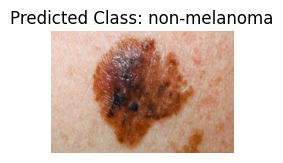

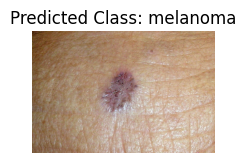

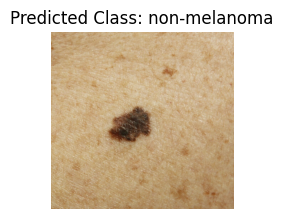

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import gdown

# Download the model file from the Google Drive link
model_file_url = 'https://drive.google.com/uc?id=1-XH0-OCkT6NLvZV2-GyDGV9Nq8xIRKq3'
model_output_path = '/content/model.pth'
gdown.download(model_file_url, model_output_path, quiet=False)

# Load the pre-trained ResNet-152 model
model = models.resnet152(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Assuming it's a binary classification (2 classes)

# Load the trained model weights
model_state_dict = torch.load(model_output_path, map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()

# Define image transformations for preprocessing
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the URLs for your image files
image_urls = [
    'https://drive.google.com/uc?id=1gP-DWZ69x2PwEAJyrbAl7ceVh3IG6H7t',
    'https://drive.google.com/uc?id=1pN62pvP0I7tRGGpZbH90eiZmPuAasC-h',
    'https://drive.google.com/uc?id=1SIKvqNJsxgTkUKFEEzShLETCe1xyv7bZ'
]

# Specify the path to save the downloaded image files
image_paths = ['/content/image1.jpg', '/content/image2.jpg', '/content/image3.jpg']

# Download the image files from Google Drive
for url, path in zip(image_urls, image_paths):
    gdown.download(url, path, quiet=False)

# Process each image and perform inference
for i, image_path in enumerate(image_paths):
    # Load and preprocess the input image
    input_image = Image.open(image_path)
    input_tensor = data_transform(input_image).unsqueeze(0)  # Add batch dimension

    # Perform inference (make predictions)
    with torch.no_grad():
        output = model(input_tensor)

    # Get the predicted class
    _, predicted_idx = torch.max(output, 1)
    predicted_class = predicted_idx.item()

    # Define class labels
    class_names = ['non-melanoma', 'melanoma']  # Replace with your actual class names

    # Display the input image and predicted class
    plt.figure(figsize=(8, 8))
    plt.subplot(1, len(image_paths), i + 1)
    plt.imshow(input_image)
    plt.title(f'Predicted Class: {class_names[predicted_class]}')
    plt.axis('off')

plt.show()
